# Natural Language Processing Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
import gc
gc.collect()
avoid_mfcc = True
rnn_units = 100
n_epochs = 50
mfcc_dim = 13
inp_dim = 161 if avoid_mfcc else mfcc_dim 

from textblob import TextBlob as tb

In [2]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 20548 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

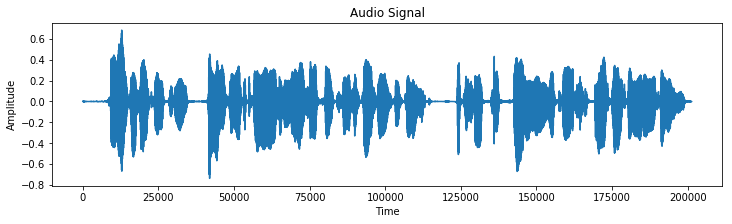

**Shape of Audio Signal** : (201317,)

**Transcript** : the youth of okochee they who were to carry into the rosy future the burden of the debt accepted failure with youth's uncalculating joy

In [3]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

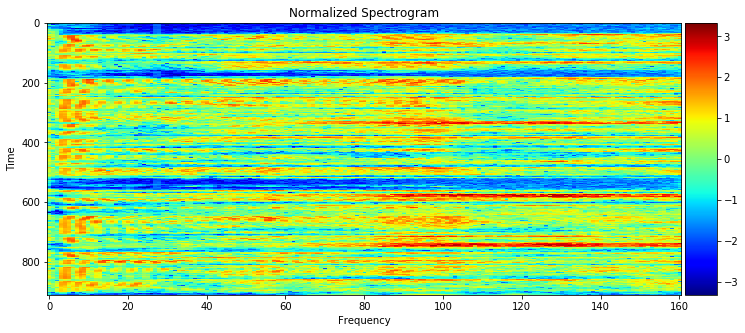

**Shape of Spectrogram** : (912, 161)

In [4]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

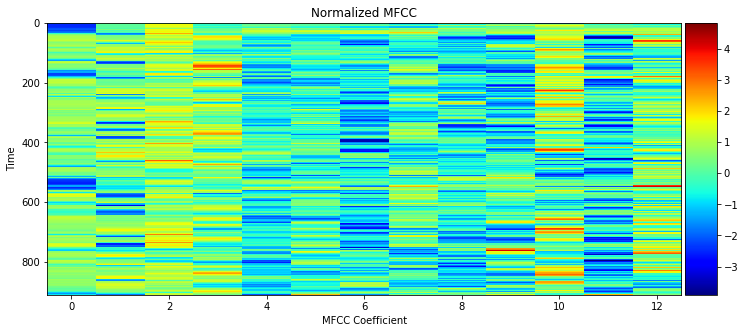

**Shape of MFCC** : (912, 13)

In [5]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [6]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model, train_multi

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This cell is moved up here so any model can be run (without having to run other models)

In [7]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(mfcc_dim=mfcc_dim) #send the dimension explicitly
#     print(avoid_mfcc)
    data_gen.spectrogram=avoid_mfcc #this is to set spectrogram to False if using MFCC
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)
    return "".join(int_sequence_to_text(pred_ints)) #Added line for further processing of the output

In [9]:
# %qtconsole

<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [16]:
model_0 = simple_rnn_model(input_dim=inp_dim) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [17]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=avoid_mfcc, # change to False if you would like to use MFCC features
            epochs = n_epochs) 
del model_0

Epoch 1/50
40/40 [==============================] - 160s 4s/step - loss: 1122.5948 - val_loss: 767.0499
Epoch 2/50
40/40 [==============================] - 153s 4s/step - loss: 879.3070 - val_loss: 753.8326
Epoch 3/50
40/40 [==============================] - 152s 4s/step - loss: 877.6638 - val_loss: 752.6276
Epoch 4/50
40/40 [==============================] - 152s 4s/step - loss: 877.4761 - val_loss: 755.1353
Epoch 5/50
40/40 [==============================] - 153s 4s/step - loss: 877.4446 - val_loss: 750.7543
Epoch 6/50
40/40 [==============================] - 154s 4s/step - loss: 877.4596 - val_loss: 752.4840
Epoch 7/50
40/40 [==============================] - 152s 4s/step - loss: 877.5282 - val_loss: 750.4950
Epoch 8/50
40/40 [==============================] - 153s 4s/step - loss: 877.6144 - val_loss: 755.2327
Epoch 9/50
40/40 [==============================] - 153s 4s/step - loss: 877.3859 - val_loss: 749.3098
Epoch 10/50
40/40 [==============================] - 153s 4s/step - loss

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [8]:
model_1 = rnn_model(input_dim=inp_dim, # change to 13 if you would like to use MFCC features
                    units=rnn_units,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 100)         78600     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 100)         400       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          2929      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 81,929
Trainable params: 81,729
Non-trainable params: 200
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [9]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=avoid_mfcc,# change to False if you would like to use MFCC features
            epochs=n_epochs) 
del model_1
gc.collect()

Epoch 1/50
40/40 [==============================] - 164s 4s/step - loss: 428.8376 - val_loss: 256.4451
Epoch 2/50
40/40 [==============================] - 154s 4s/step - loss: 260.7747 - val_loss: 231.2410
Epoch 3/50
40/40 [==============================] - 153s 4s/step - loss: 251.9023 - val_loss: 226.9238
Epoch 4/50
40/40 [==============================] - 154s 4s/step - loss: 247.1812 - val_loss: 209.5849
Epoch 5/50
40/40 [==============================] - 154s 4s/step - loss: 239.9728 - val_loss: 206.4203
Epoch 6/50
40/40 [==============================] - 154s 4s/step - loss: 225.1723 - val_loss: 198.8894
Epoch 7/50
40/40 [==============================] - 153s 4s/step - loss: 211.7989 - val_loss: 182.4438
Epoch 8/50
40/40 [==============================] - 154s 4s/step - loss: 203.8951 - val_loss: 175.5978
Epoch 9/50
40/40 [==============================] - 155s 4s/step - loss: 196.5906 - val_loss: 169.7951
Epoch 10/50
40/40 [==============================] - 152s 4s/step - loss:

355

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [10]:
model_2= cnn_rnn_model(input_dim=inp_dim, # change to 13 if you would like to use MFCC features
                        filters=100,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='same',
                        units=rnn_units, drop_fraction = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         177200    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 100)         20100     
_________________________________________________________________
bn_simp_rnn (BatchNormalizat (None, None, 100)         400       
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
__________

/home/thojo/.local/lib/python3.6/site-packages/keras/layers/recurrent.py:989: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [11]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            epochs = n_epochs, 
            spectrogram=avoid_mfcc) # change to False if you would like to use MFCC features
del model_2
gc.collect()

Epoch 1/50
40/40 [==============================] - 137s 3s/step - loss: 321.2730 - val_loss: 216.8772
Epoch 2/50
40/40 [==============================] - 132s 3s/step - loss: 236.9455 - val_loss: 193.1751
Epoch 3/50
40/40 [==============================] - 132s 3s/step - loss: 219.4014 - val_loss: 181.1359
Epoch 4/50
40/40 [==============================] - 132s 3s/step - loss: 207.7457 - val_loss: 170.3642
Epoch 5/50
40/40 [==============================] - 132s 3s/step - loss: 200.1204 - val_loss: 164.6024
Epoch 6/50
40/40 [==============================] - 132s 3s/step - loss: 194.3525 - val_loss: 158.6044
Epoch 7/50
40/40 [==============================] - 133s 3s/step - loss: 189.7905 - val_loss: 154.5894
Epoch 8/50
40/40 [==============================] - 133s 3s/step - loss: 186.2524 - val_loss: 150.8605
Epoch 9/50
40/40 [==============================] - 132s 3s/step - loss: 182.8841 - val_loss: 146.7513
Epoch 10/50
40/40 [==============================] - 133s 3s/step - loss:

7565

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [12]:
model_3 = deep_rnn_model(input_dim=inp_dim, # change to 13 if you would like to use MFCC features
                         units=rnn_units, # was 200
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 100)         78600     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 100)         400       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 100)         60300     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 100)         400       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          2929      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [13]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5',
            epochs = n_epochs,
            spectrogram=avoid_mfcc) # change to False if you would like to use MFCC features
del model_3
gc.collect()

Epoch 1/50
40/40 [==============================] - 178s 4s/step - loss: 446.3138 - val_loss: 235.8692
Epoch 2/50
40/40 [==============================] - 169s 4s/step - loss: 256.0672 - val_loss: 215.8807
Epoch 3/50
40/40 [==============================] - 170s 4s/step - loss: 249.0034 - val_loss: 212.9478
Epoch 4/50
40/40 [==============================] - 169s 4s/step - loss: 241.4292 - val_loss: 204.5365
Epoch 5/50
40/40 [==============================] - 170s 4s/step - loss: 230.9748 - val_loss: 200.7878
Epoch 6/50
40/40 [==============================] - 169s 4s/step - loss: 218.2860 - val_loss: 196.7244
Epoch 7/50
40/40 [==============================] - 169s 4s/step - loss: 207.2641 - val_loss: 181.1930
Epoch 8/50
40/40 [==============================] - 168s 4s/step - loss: 198.7657 - val_loss: 172.5873
Epoch 9/50
40/40 [==============================] - 169s 4s/step - loss: 191.7498 - val_loss: 166.5148
Epoch 10/50
40/40 [==============================] - 169s 4s/step - loss:

7775

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [14]:
model_4 = bidirectional_rnn_model(input_dim=inp_dim, # change to 13 if you would like to use MFCC features
                                  units=rnn_units ) # Adding dropouts (even 10%) leads to exploding gradients

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         157200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 163,029
Trainable params: 163,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [15]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            epochs = n_epochs,
            spectrogram=avoid_mfcc) # change to False if you would like to use MFCC features
del model_4
gc.collect()

Epoch 1/50
40/40 [==============================] - 177s 4s/step - loss: 471.2007 - val_loss: 284.8376
Epoch 2/50
40/40 [==============================] - 170s 4s/step - loss: 324.6857 - val_loss: 271.1675
Epoch 3/50
40/40 [==============================] - 168s 4s/step - loss: 316.0105 - val_loss: 265.1167
Epoch 4/50
40/40 [==============================] - 168s 4s/step - loss: 312.1206 - val_loss: 265.2727
Epoch 5/50
40/40 [==============================] - 168s 4s/step - loss: 311.1095 - val_loss: 264.6360
Epoch 6/50
40/40 [==============================] - 169s 4s/step - loss: 300.9241 - val_loss: 234.9538
Epoch 7/50
40/40 [==============================] - 168s 4s/step - loss: 275.9132 - val_loss: 220.6328
Epoch 8/50
40/40 [==============================] - 169s 4s/step - loss: 260.8614 - val_loss: 220.0169
Epoch 9/50
40/40 [==============================] - 168s 4s/step - loss: 253.4287 - val_loss: 212.2271
Epoch 10/50
40/40 [==============================] - 169s 4s/step - loss:

481

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [8]:
## (Optional) A deep birectional RNN model 
# n_epochs=40
model_5 = deep_bd_rnn_model(input_dim=inp_dim, # change to 13 if you would like to use MFCC features
                         units=rnn_units, # was 200
                         recur_layers=3,
                         drop_fraction=0.2)
# note 1: Not doing dropout here so that the pure effect of such an architecture can be seen.
# note 2: Now tried adding dropout and that is leading to OOM error with batch_size=256 (all other models here use a size of 256)
# I'm therefore running it with batch_size=128
# Sure enough, overfitting is clear to see.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         157200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
__________

# Note:
Model_5 is a deep (3-layer) bidirectional RNN model + TimeDistributed Dense.

In [9]:
#training with batch size of 200 to dodge the OOM error with 256
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            epochs = n_epochs,
            spectrogram=avoid_mfcc) # set to False if you would like to use MFCC features
del model_5
gc.collect()

Epoch 1/50
102/102 [==============================] - 880s 9s/step - loss: 313.1736 - val_loss: 213.9037
Epoch 2/50
102/102 [==============================] - 864s 8s/step - loss: 250.5902 - val_loss: 202.4913
Epoch 3/50
102/102 [==============================] - 865s 8s/step - loss: 235.1947 - val_loss: 184.4150
Epoch 4/50
102/102 [==============================] - 865s 8s/step - loss: 218.5509 - val_loss: 168.0504
Epoch 5/50
102/102 [==============================] - 865s 8s/step - loss: 201.4776 - val_loss: 153.0070
Epoch 6/50
102/102 [==============================] - 866s 8s/step - loss: 186.9920 - val_loss: 140.5876
Epoch 7/50
102/102 [==============================] - 866s 8s/step - loss: 176.1521 - val_loss: 132.5954
Epoch 8/50
102/102 [==============================] - 863s 8s/step - loss: 168.2879 - val_loss: 128.1319
Epoch 9/50
102/102 [==============================] - 865s 8s/step - loss: 162.6972 - val_loss: 122.9271
Epoch 10/50
102/102 [==============================] - 

11053

## Model 6 

## __Deep(er) CNN + RNN__
Here, the architecture is as follows.
1. Two convolutional layers
2. One-layer RNN (bidirectional GRU)'
3. Batch normalization in each of the convolutional layers and the bidirectional GRU layers)
4. Dropout layers with 20% dropout to prevent overfitting. 
5. Dense layer
6. Softmax layer

Gradients are clipped to 1 to prevent exploding gradients. 
I have checked this deeper model with and without MFCC and it seems that adding the extra convolutional layer does not improve performance on the validation set. 

In [11]:
#reset n_epochs for trials
# n_epochs = 50
avoid_mfcc = True
inp_dim = 161 if avoid_mfcc else mfcc_dim 

from sample_models import *
# specify the model # p_size=1 # rnn_units=32
f_size = 100
k_size = 11
r_layers=1 #3
cnn_layers=2
conv_stride = 2
model_6=final_model(input_dim=inp_dim, # use 13 if you would like to use MFCC features
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,  
                        recur_layers=r_layers, 
                        drop_fraction=0.2)
print(model_6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         177200    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 100)         400       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 200)         220200    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
__________

In [12]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5', 
            epochs = n_epochs,
            spectrogram=avoid_mfcc) # change to False if you would like to use MFCC features
del model_6
gc.collect()

Epoch 1/50
102/102 [==============================] - 140s 1s/step - loss: 246.4019 - val_loss: 181.9860
Epoch 2/50
102/102 [==============================] - 136s 1s/step - loss: 207.3457 - val_loss: 161.5985
Epoch 3/50
102/102 [==============================] - 137s 1s/step - loss: 193.7219 - val_loss: 152.6399
Epoch 4/50
102/102 [==============================] - 137s 1s/step - loss: 185.9512 - val_loss: 145.9644
Epoch 5/50
102/102 [==============================] - 136s 1s/step - loss: 180.2808 - val_loss: 141.1453
Epoch 6/50
102/102 [==============================] - 137s 1s/step - loss: 175.9881 - val_loss: 137.8668
Epoch 7/50
102/102 [==============================] - 137s 1s/step - loss: 172.3735 - val_loss: 134.6889
Epoch 8/50
102/102 [==============================] - 137s 1s/step - loss: 169.2770 - val_loss: 131.8472
Epoch 9/50
102/102 [==============================] - 137s 1s/step - loss: 166.6610 - val_loss: 130.2353
Epoch 10/50
102/102 [==============================] - 

11933

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

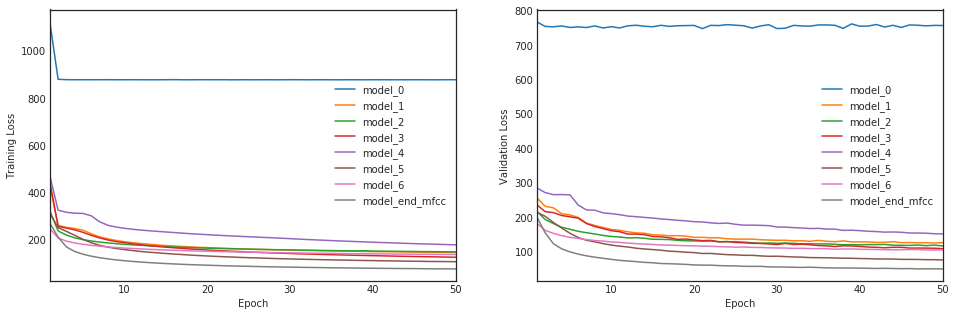

In [37]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

# Project Notes


In this notebook, I have attempted several standout suggestions of the project. In the previous notebook [here](https://github.com/gotamist/nlp/tree/master/3_vui_speech_recognizer), I have compared the models built with and without MFCC and completed the requirements. 
I have 
experimented with a deeper CNN architecture vs a deeper RNN architecture.   I have compared their performance by looking at validation loss rather than by looking at the text generated on some sample files because it's hard to tell apart their performance in that way. I am only showing the one I picked in the end, not the other ones that I could have done instead. I have tried one and two CNN layers and 1-5 RNN layers.


In addition, I performed a number of experiments on the optimization hyperparameters.  The  first two were the learning rate, `lr` and `clipnorm`  in the optimizer.
- Varying `lr` between 0.001 and 0.1, I found that the best performance is at `lr=0.03-0.05`
- Leaving clipnorm at 5 can cause NaNs in some of the models, especially the deeper ones.  I have set `clipnorm=1` for that reason. I expected performance to deteriorate a little (slower reduction of validation loss), but this was not the case, to my surprise.

The most interesting hyperparameter was`batch_size`. Having experienced out-of-memory errors and other limitations, I decided to build a deep-learning machine with a GPU myself for this project (and hopefully, future NLP work).  At first, running the same code, I found that there was no appreciable increase in speed from the new GPU.  This is because of leaving the batch size at the small default value of 20.  Then the GPU is not doing much and the CPU is the bottleneck.  The benefit from the GPU comes by increasing `batch_size`, when most of the workload can be transferred to the GPU.  Indeed, the computation was sped up tremendously.  However, I found that increasing the batch_size led to poorer performance.  The smaller the batch size, the better the performance. 
> I tried `batch_size` of 32, 64, 128, 256 and 512 and found that a good tradeoff between loss and speed was at `batch_size=64`.  I was able to invest the greater speed into running a higher number of epochs instead in order to reduce loss that way.

I have run all the models for 50 epochs here as I discovered that while in the first 20-30 epochs, some models can be better than others, the ordering can change when the number of epochs is higher. It takes a large number of epochs to reveal overfitting.

Two other features that I added here, but found them not helping performance:
1. max pooling layers and 
2. dilated convolutions.  

So, I have implemented those and got them to work (can be seen in sample_models.py), but left them out of the model_end_mfcc (simply set the dilation rate back to 1, which means, no dilation is applied). In this notebook, I'm only working with MFCC (see  for a comparison between MFCC features and full spectrogram - MFCC wins). Instead of that comparison, here, the focus is on working with a large dataset (360 hours of recordings from LibriSpeech) and on adding a language model to the decoding.

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__
The training loss as well as validation loss are very poor on the simple model.  The performance is much better in the case of the RNN model (model_1) as well as the other models.  

Model_2, with the CNN shows much promise and is significantly better in performance. I'd like to have this in my final model.

In the case of model_3, which is the deep RNN model, training performance keeps getting better whereas the validation performance does not increase quite as fast.  This suggests that some regularization in the final model below - perhaps dropout will help. Between SimpleRNN, LSTM and GRU, performance is the best with a __GRU__.

The birectional RNN model, model_4 is more promising - the validation error also decreases with training (even though it is higher at first, it does not seem to hit a plateau. This makes sense from what we know about bidirectional models also making use of the future while training. 

model_5 (optional), which is a deep bidrectional RNN model performs the best of all intially.  OOM errors appeared when adding dropout, forcing a lower `batch_size`.  But having run this without dropout, it was easy to see the tremendous overfitting. These suggest that for the final model it would be useful to combine a deep CNN with a multilayer bidirectonal RNN and add regularization.  

__note__ After building model_end, I've run this cell again to compare its performance with the others.  Comments below in the answer to Question 2.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__
Each of the individual models model_{0-5} was helpful in deciding the final model.
The final architecture has a __convolutional layer__ as this was seen in model_2 to have significant reduction in the CTC_cost. It has dropout (20%) to prevent overfitting.  That part seems to be working (no evidence of overfitting) although it appears that the training is too slow and there would be a benefit from a higher number of epochs as the validation losses were the lowest in model_end when I did not add so much dropout.  I had tried upto 40% dropout earlier. 

That is followed by a deep RNN layer, where I have __five layers of bidirectional GRUs__. Each of these layers is slower than unidirectional RNNs, but the benefit on the loss is worthwhile. A surprising finding from the previous models was that using `rnn_units=200` did not deliver better performance than `rnn_units=100`. Therefore, in the construction of model_end, I have used only `rnn_units=100` to save on computational cost.

There is __batch normalization__ for the conv1D as well as each RNN layer to improve stability of the gradient descent. 
Finally, there is a __TimeDistributed dense__ layer with a __softmax activation__ for the output. 

In order to prevent gradients from diverging, I'm using __clipnorm=1__ as an argument to the optimizer in train_utils.py.

It is clear from the predictions below that a __language model would really help__!

Below, I have looked the predictions from model_end and also checked the __MFCC__ version of it.  The MFCC version is surprisingly good.  It has even a slightly lower loss (93.7 with MFCC vs 97.8 without) than the one that does not use MFCC, even though the number of trainable parameters is substantially lower.

Further, I tested a deeper model called __model_opt__ (not shown below). This model is much like model_end except that it has an extra convolutional layer __(2 convolutional + 3 bidrectional RNN)__ and has a higher dropout rate (40%) to deal with overfitting.  This too, I've checked __with and without MFCC__ and did not find a substantial difference in performance between those two cases. Here, I find the model_opt does not perform as well as any of the other models.  Only model_0 is worse.  


# Final model with MFCC

In [8]:
avoid_mfcc = False # in other words, use MFCC
inp_dim = 161 if avoid_mfcc else mfcc_dim 

# specify the model # p_size=1 # rnn_units=32
f_size = 100
k_size = 11
r_layers=5 #3
cnn_layers=1
conv_stride = 2
model_end_mfcc=final_model(input_dim=inp_dim, # use mfcc_dim if you would like to use MFCC features
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,  
                        recur_layers=r_layers, 
                        drop_fraction=0.2)
print(model_end_mfcc.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         14400     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 100)         400       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         120600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         180600    
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [9]:
##### from train_utils import *
train_model(input_to_softmax=model_end_mfcc, 
            pickle_path='model_end_mfcc.pickle', 
            save_model_path='model_end_mfcc.h5',
            mfcc_dim=mfcc_dim,
            spectrogram=avoid_mfcc, # set to False if you would like to use MFCC features
            epochs = n_epochs) 

Epoch 1/50
160/160 [==============================] - 1094s 7s/step - loss: 270.2349 - val_loss: 200.9550
Epoch 2/50
160/160 [==============================] - 1079s 7s/step - loss: 210.5562 - val_loss: 154.5599
Epoch 3/50
160/160 [==============================] - 988s 6s/step - loss: 169.2897 - val_loss: 122.6162
Epoch 4/50
160/160 [==============================] - 1006s 6s/step - loss: 149.9146 - val_loss: 107.7930
Epoch 5/50
160/160 [==============================] - 997s 6s/step - loss: 138.3439 - val_loss: 98.8609
Epoch 6/50
160/160 [==============================] - 946s 6s/step - loss: 130.0453 - val_loss: 92.4127
Epoch 7/50
160/160 [==============================] - 989s 6s/step - loss: 123.7052 - val_loss: 87.3830
Epoch 8/50
160/160 [==============================] - 1037s 6s/step - loss: 118.5173 - val_loss: 83.5007
Epoch 9/50
160/160 [==============================] - 945s 6s/step - loss: 114.3136 - val_loss: 80.1852
Epoch 10/50
160/160 [==============================] - 9

In [25]:
train_pred=get_predictions(index=2, 
                partition='train',
                input_to_softmax=final_model(input_dim=inp_dim, 
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,                     
                        recur_layers=r_layers),
                model_path='./results/model_end_mfcc.h5')

--------------------------------------------------------------------------------
True transcription:

far up the lake eighteen miles above the town the eye of this cheerful camp follower of booms had spied out a graft
--------------------------------------------------------------------------------
Predicted transcription:

far ut the lake eightteen mils abo the town to ey of dis cherple can flolowor o bons had xpide ut a graft
--------------------------------------------------------------------------------


In [12]:
valid_pred=get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=inp_dim, 
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,                     
                        recur_layers=r_layers),
                model_path='./results/model_end_mfcc.h5')
valid_blob = tb( valid_pred )
print('With basic spelling correction (TextBlob)')
print( valid_blob.correct() )

--------------------------------------------------------------------------------
True transcription:

the bogus legislature numbered thirty six members
--------------------------------------------------------------------------------
Predicted transcription:

the bothis leges latured nuberd thirty six members
--------------------------------------------------------------------------------
With basic spelling correction (TextBlob)
the this legs natured number thirty six members


## Loss using spectrogram (not mfcc) just for comparison

Here we use the same architecture, with the only difference being that we don't use MFCC features.

In [8]:
avoid_mfcc = True 
inp_dim = 161 if avoid_mfcc else mfcc_dim 

f_size = 100
k_size = 11
r_layers=5 
cnn_layers=1
conv_stride = 2
model_end_spectrogram=final_model(input_dim=inp_dim, # use mfcc_dim if you would like to use MFCC features
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,  
                        recur_layers=r_layers, 
                        drop_fraction=0.2)
print(model_end_spectrogram.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         177200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 100)         400       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         120600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         180600    
__________

In [10]:
##### from train_utils import *
train_model(input_to_softmax=model_end_spectrogram, 
            pickle_path='model_end_spectrogram.pickle', 
            save_model_path='model_end_spectrogram.h5',
            mfcc_dim=mfcc_dim,
            spectrogram=avoid_mfcc, # set to False if you would like to use MFCC features
            epochs = n_epochs) 

Epoch 1/50
107/107 [==============================] - 778s 7s/step - loss: 256.4203 - val_loss: 210.0891
Epoch 2/50
107/107 [==============================] - 800s 7s/step - loss: 238.4262 - val_loss: 184.5495
Epoch 3/50
107/107 [==============================] - 781s 7s/step - loss: 211.8275 - val_loss: 165.7943
Epoch 4/50
107/107 [==============================] - 736s 7s/step - loss: 192.1393 - val_loss: 149.9627
Epoch 5/50
107/107 [==============================] - 717s 7s/step - loss: 176.8263 - val_loss: 134.7403
Epoch 6/50
107/107 [==============================] - 718s 7s/step - loss: 165.2754 - val_loss: 124.6592
Epoch 7/50
107/107 [==============================] - 721s 7s/step - loss: 157.0969 - val_loss: 117.5877
Epoch 8/50
107/107 [==============================] - 721s 7s/step - loss: 150.7431 - val_loss: 111.8798
Epoch 9/50
107/107 [==============================] - 721s 7s/step - loss: 145.2571 - val_loss: 108.2397
Epoch 10/50
107/107 [==============================] - 

# Add language model (kenlm)
Follow the [instructions here](https://kheafield.com/code/kenlm/)

Create the lines.txt file using `lm_helpers.py`.  Then, having installed Boost and then kenlm, create the `.arpa` file for this corpus.

For 3-gram training:

`~/installs/kenlm/build/bin/lmplz -o 3 -S 50% <corpus_360_lines.txt >corpus_360_lines.arpa`

For 5-gram training:

`~/installs/kenlm/build/bin/lmplz -o 5 -S 30% <corpus_360_lines.txt >5_gram_corpus_360.arpa`

Note that if you get a malloc error, then just try dropping the 50% to a smaller number.  Default is 80% and you might not have enough available memory. 

Now use this command to build a binary:

`~/installs/kenlm/build/bin/build_binary corpus_360_lines.arpa corpus_360_lines.binary`

In [12]:
from lm_helpers import * 
from nltk.corpus import words as nltk_words
import kenlm

In [13]:
english=nltk_words.words()
st = generate_corpus("./train_corpus.json")
train_words = wordset_from_corpus(st)
ken5model = kenlm.Model('5_gram_corpus_360.binary')
ken2model = kenlm.Model('2_gram_corpus_360.binary')

## Performance with language model on line from training set

In [27]:
train_pred=get_predictions(index=2, 
                partition='train',
                input_to_softmax=final_model(input_dim=inp_dim, 
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,                     
                        recur_layers=r_layers),
                model_path='./results/model_end_mfcc.h5')
#Simple spelling fix using textblob (tb)
train_blob = tb( train_pred )
print('With basic spelling correction (TextBlob)')
print( train_blob.correct() )
print('------------------------------------------------------------------------')
print('Language model bigram prediction - neighborhoods in LEVENSHTEIN distance\n')
print( bigram_predict(train_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model, radius=3))

print('------------------------------------------------------------------------')
print('Language model TRIGRAM prediction - neighborhoods in Levenshtein distance\n')
print( trigram_predict(train_pred, train_dictionary=train_words, predict_dictionary=english,lmodel=ken5model,radius=3))

print('------------------------------------------------------------------------')
print('Language model bigram prediction - neighborhoods in DOLGOPOLSKY distance\n')
print( bigram_dolgoposlky_predict(train_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model, radius=2))

print('------------------------------------------------------------------------')
print('Language model TRIGRAM prediction - neighborhoods in Dolgopolsky distance\n')
print( trigram_dolgoposlky_predict(train_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model, radius=2))

--------------------------------------------------------------------------------
True transcription:

far up the lake eighteen miles above the town the eye of this cheerful camp follower of booms had spied out a graft
--------------------------------------------------------------------------------
Predicted transcription:

far ut the lake eightteen mils abo the town to ey of dis cherple can flolowor o bons had xpide ut a graft
--------------------------------------------------------------------------------
With basic spelling correction (TextBlob)
far ut the lake eighteen miss ago the town to by of dis chere can follower o bons had side ut a graft
------------------------------------------------------------------------
Language model bigram prediction - neighborhoods in LEVENSHTEIN distance

far and wide lake eighteen in the the town to the of dis there can flower o king had made a a graft
------------------------------------------------------------------------
Language model TRIGRAM p

## Performance with language model on line from validation set

In [19]:
from lm_helpers import *
valid_pred=get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=inp_dim, 
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,                     
                        recur_layers=r_layers),
                model_path='./results/model_end_mfcc.h5')
valid_blob = tb( valid_pred )
print('With basic spelling correction (TextBlob)\n')
print( valid_blob.correct() )
print('------------------------------------------------------------------------')
print('Language model bigram prediction - neighborhoods in LEVENSHTEIN distance\n')
print( bigram_predict(valid_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model, radius=2.5)) 

print('------------------------------------------------------------------------')
print('Language model TRIGRAM prediction - neighborhoods in Levenshtein distance\n')
print( trigram_predict(valid_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model, radius=2.5))

print('------------------------------------------------------------------------')
print('Language model bigram prediction - neighborhoods in DOLGOPOLSKY distance\n')
print( bigram_dolgopolsky_predict(valid_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model, radius=2.5))

print('------------------------------------------------------------------------')
print('Language model TRIGRAM prediction - neighborhoods in Dolgopolsky distance\n')
print( trigram_dolgopolsky_predict(valid_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken5model,radius=2.5))


--------------------------------------------------------------------------------
True transcription:

the bogus legislature numbered thirty six members
--------------------------------------------------------------------------------
Predicted transcription:

the bothis leges latured nuberd thirty six members
--------------------------------------------------------------------------------
With basic spelling correction (TextBlob)

the this legs natured number thirty six members
------------------------------------------------------------------------
Language model bigram prediction - neighborhoods in LEVENSHTEIN distance

the this less nature number thirty six members
------------------------------------------------------------------------
Language model TRIGRAM prediction - neighborhoods in Levenshtein distance

the this less nature number thirty six members
------------------------------------------------------------------------
Language model bigram prediction - neighborhoods in DOLG

In [14]:
from lm_helpers import *
train_pred=get_predictions(index=2, 
                partition='train',
                input_to_softmax=final_model(input_dim=mfcc_dim, 
                        filters=f_size,
                        kernel_size=k_size, #11 
                        conv_stride=conv_stride, #2
                        conv_border_mode='same',
                        units=rnn_units,
                        num_cnn=cnn_layers,                     
                        recur_layers=r_layers),
                model_path='./results/model_end_mfcc.h5')
#Simple spelling fix using textblob (tb)
train_blob = tb( train_pred )
print('With basic spelling correction (TextBlob)')
print( train_blob.correct() )
print('------------------------------------------------------------------------')
print('Language model bigram prediction - neighborhoods in LEVENSHTEIN distance\n')
print( bigram_predict(train_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken2model, radius=3))

print('------------------------------------------------------------------------')
print('Language model bigram prediction - neighborhoods in DOLGOPOLSKY distance\n')
print( bigram_dolgopolsky_predict(train_pred, train_dictionary=train_words, predict_dictionary=english, lmodel=ken2model, radius=2))


--------------------------------------------------------------------------------
True transcription:

far up the lake eighteen miles above the town the eye of this cheerful camp follower of booms had spied out a graft
--------------------------------------------------------------------------------
Predicted transcription:

far ut the lake eightteen mils abo the town to ey of dis cherple can flolowor o bons had xpide ut a graft
--------------------------------------------------------------------------------
With basic spelling correction (TextBlob)
far ut the lake eighteen miss ago the town to by of dis chere can follower o bons had side ut a graft
------------------------------------------------------------------------
Language model bigram prediction - neighborhoods in LEVENSHTEIN distance

far as the lake eighteen in the the town to the of dis there can flower o king had made a a graft
------------------------------------------------------------------------
Language model bigram pred